In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Visualization for class predictions over learning time

In [169]:
import sys

sys.path.insert(0, '/home/nathan/caffe-segnet-crf/python')
import caffe
caffe.set_mode_gpu()

sys.path.insert(0, '/home/nathan/histo-seg/v2/core')
import colorNormalization as cnorm

import os, glob, shutil, cv2
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [145]:
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA

In [10]:
def img2caffe(img):
    img = img.transpose((2,0,1))
    img = np.expand_dims(img, 0)
    
    return img

### Set up a way to parse a mask into one of our classes. We'll use 5 classes:
- Stroma only
- Grade 3 + Stroma
- Grade 4/5 + Stroma
- Benign + Stroma
- Grade 4/5 only

In [195]:
def mask2classes(mask):
    u = np.unique(mask)
    if all(u == 3): # ST
        return 0
#         return -1
    elif 0 in u and 1 not in u and 2 not in u: # 3
        return 1
#         return -1
    elif 0 not in u and 1 in u and 2 not in u: # 4
        return 2
#         return -1
    elif 0 not in u and 1 not in u and 2 in u: # Benign
        return 3
#         return -1
    elif all(u == 1): # all 4
#         return 4
        return -1
    else:
        return -1

In [167]:
image_types = {
    0: ['ST','.', 'r'],
    1: ['G3','o', 'b'],
    2: ['G4','1', 'm'],
    3: ['BN','^', 'g'],
    4: ['44','v', 'k']
}

In [231]:
weights_list = ['/home/nathan/histo-seg/semantic-pca/weights/whole_set_512/batchnorm_segnet_pca_90000.caffemodel']

deploy_proto = '/home/nathan/histo-seg/semantic-pca/code/segnet_basic_deploy_10X.prototxt'

## All of them
image_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/data/_data_origin/jpg/*jpg'))
masks_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/data/_data_origin/mask/*png'))

weights = weights_list[0]
net = caffe.Net(deploy_proto, weights, caffe.TEST)

In [223]:
# Test our function

use_masks_list = [mask for mask in masks_list if mask2classes(cv2.imread(mask,-1)) >= 0]
use_image_list = [img for mask,img in zip(masks_list, image_list) if mask2classes(cv2.imread(mask,-1)) >= 0]
use_masks_label = [mask2classes(cv2.imread(mask,-1)) for mask in use_masks_list]
use_masks_label = np.asarray(use_masks_label)

print np.unique(use_masks_label)
print len(use_masks_list)

[0 1 2 3]
323


### Fill up a matrix

323
(323, 5476)
(323, 3517)
Fitting
Plotting
0
1
2
3
4
Done


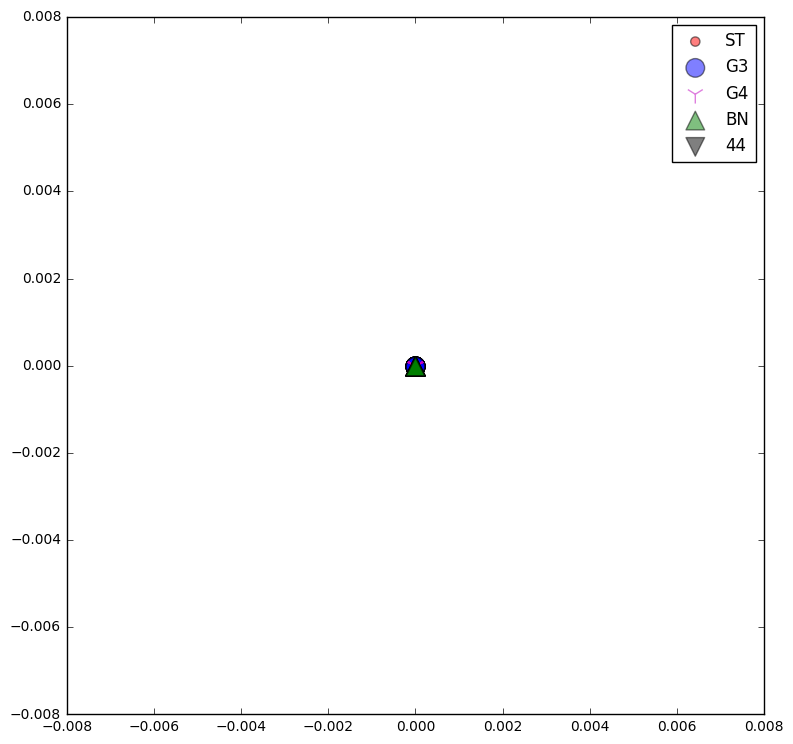

In [232]:
test_layer = 'pool4'
x_vectors = []
for image in use_image_list:
    img_data = cv2.imread(image)
    img_data = cv2.resize(img_data, dsize=(600,600))
    img_data = cnorm.normalize(img_data)
    img_caffe = img2caffe(img_data)

    obs = net.forward(data=img_caffe)
    
    x_vectors.append(net.blobs[test_layer].data[0,0:4,:,:].ravel())
    
print len(x_vectors)
    
x = np.vstack(x_vectors)
print x.shape

x = x[:, (np.var(x, axis=0) > 0)]
print x.shape

transform = MDS(n_components=2)
print 'Fitting'
x_manifold = transform.fit_transform(x)
print 'Plotting'

fig, ax = plt.subplots(1,1,figsize=(9,9))

for label in image_types.iterkeys():
    print label
    ax.scatter(x_manifold[use_masks_label==label, 0], x_manifold[use_masks_label==label, 1],
                label=image_types[label][0], 
                marker=image_types[label][1],
                c=image_types[label][2],
                alpha=0.5,
                s = 180)
    
ax.legend(scatterpoints=1)
print 'Done'